# Spectral analysis with Gammapy

## Introduction

This notebook explains how to use the functions and classes in [gammapy.spectrum](http://docs.gammapy.org/en/latest/spectrum/index.html).

Based on a datasets of 4 Crab observations with H.E.S.S. (simulated events for now) we will perform a full region based spectral analysis, i.e. extracting source and background counts from certain 
regions, and fitting them using the forward-folding approach.

Data handling:

* [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html)
* [gammapy.data.DataStoreObservation](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStoreObservation.html)
* [gammapy.data.Target](http://docs.gammapy.org/en/latest/api/gammapy.data.Target.html)
* [gammapy.data.ObservationStats](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationStats.html)
* [gammapy.data.ObservationSummary](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationSummary.html)

To extract the 1-dim spectral information:

* [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumExtraction](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumExtraction.html)
* [gammapy.background.reflected_regions_background_estimate](http://docs.gammapy.org/en/latest/api/gammapy.background.reflected_regions_background_estimate.html)


For the global fit (using Sherpa and WSTAT in the background):

* [gammapy.spectrum.SpectrumFit](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumFit.html)
* [gammapy.spectrum.models.PowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.PowerLaw.html)
* [gammapy.spectrum.models.ExponentialCutoffPowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.ExponentialCutoffPowerLaw.html)
* [gammapy.spectrum.models.LogParabola](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.LogParabola.html)

To compute flux points (a.k.a. "SED" = "spectral energy distribution")

* [gammapy.spectrum.SpectrumResult](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumResult.html)
* [gammapy.spectrum.DifferentialFluxPoints](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.DifferentialFluxPoints.html)
* [gammapy.spectrum.SpectrumEnergyGroupMaker](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumEnergyGroupMaker.html)
* [gammapy.spectrum.FluxPointEstimator](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.FluxPointEstimator.html)

We know this is a lot of classes and complexity.
The reason is that we have created Gammapy as a flexible, modular toolbox to implement such analyses.

We will add more high-level classes and command line tools that execute the common workflows like the one done here by hand as a pipeline and output a nice summary, to make the common cases easy.

Feedback welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion

from gammapy.data import DataStore, ObservationList, Target
from gammapy.data import ObservationStats, ObservationSummary
from gammapy.image import SkyMask
from gammapy.background import reflected_regions_background_estimate
from gammapy.spectrum import SpectrumExtraction, SpectrumObservation, SpectrumFit, SpectrumResult
from gammapy.spectrum.models import PowerLaw, ExponentialCutoffPowerLaw, LogParabola
from gammapy.spectrum import DifferentialFluxPoints, SpectrumEnergyGroupMaker, FluxPointEstimator

## Load Data

First, we select and load some H.E.S.S. observations of the Crab nebula (simulated events for now).

We will access the events, effective area, energy dispersion, livetime and PSF for containement correction.

In [3]:
DATA_DIR = '$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2'

datastore = DataStore.from_dir(DATA_DIR)
obs_ids = [23523, 23526, 23559, 23592]

observations = ObservationList(datastore.obs(obs_id) for obs_id in obs_ids)
print(observations[0])

Info for OBS_ID = 23523
- Start time: 53343.92
- Pointing pos: RA 83.63 deg / Dec 21.51 deg
- Observation duration: 1687.0 s
- Dead-time fraction: 6.240 %



## Define Target Region

The next step is to define a signal extraction region, also known as on region. In the simplest case this is just a [CircleSkyRegion](http://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html#regions.CircleSkyRegion), but here we will use the ``Target`` class in gammapy that is useful for book-keeping if you run several analysis in a script.

In [4]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit='deg', frame='icrs')
on_region_radius = Angle('0.2 deg')
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

target = Target(on_region=on_region, name='Crab', tag='crab_example')
# print(target)

## Load exclusion mask

Most analysis will require a mask to exclude regions with possible gamma-ray signal from the background estimation procedure. For simplicity, we will use a pre-cooked exclusion mask from gammapy-extra which includes (or rather excludes) all source listed in the [TeVCat](http://tevcat.uchicago.edu/) and cutout only the region around the crab.

TODO: Change to [gamma-cat](https://gammapy.github.io/gamma-cat/)

In [5]:
EXCLUSION_FILE = '$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits'

allsky_mask = SkyMask.read(EXCLUSION_FILE)
exclusion_mask = allsky_mask.cutout(
    position=target.on_region.center,
    size=Angle('7 deg'),
)

## Estimate background

Next we will manually perform a background estimate by placing [reflected regions](http://docs.gammapy.org/en/latest/background/reflected.html) around the pointing position and looking at the source statistics. In a real analysis you probably don't want to this every time. In this case you can also pass the background estimation parameters directly to the ``SpectrumExtraction`` class, as shown below in [Extract Spectrum](#extract_spectrum).

In [6]:
bkg = [
    reflected_regions_background_estimate(
        on_region=target.on_region,
        pointing=obs.pointing_radec,
        exclusion=exclusion_mask,
        events=obs.events
    ) for obs in observations
]

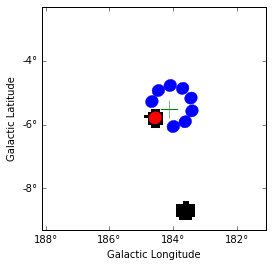

In [7]:
test_obs = 1
test_pointing = observations[test_obs].pointing_radec

fig, ax, cbar = exclusion_mask.plot()
target.on_region.plot(ax=ax, color='red')

# without this the axis limits are changed when calling scatter
ax.autoscale(enable=False)
ax.scatter(test_pointing.galactic.l, test_pointing.galactic.b,
           transform=ax.get_transform('galactic'),
           marker='+', color='green', s=300)

for off in bkg[test_obs].off_region:
    off.plot(ax=ax, color='blue')

## Source statistic

Next we're going to look at the overall source statistics in our signal region. For more info about what debug plots you can create check out the [ObservationSummary](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationSummary.html#gammapy.data.ObservationSummary) class.

*** Observation summary report ***
Observation Id: 23526
Livetime: 0.437 h
On events: 200
Off events: 148
Alpha: 0.125
Bkg events in On region: 18.50
Excess: 181.50
Excess / Background: 9.81
Gamma rate: 7.63 1 / min
Bkg rate: 0.71 1 / min
Sigma: 20.96



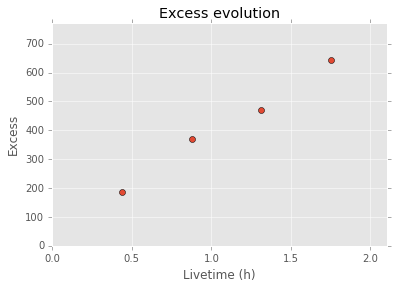

In [8]:
stats = []
for _obs, _bkg in zip(observations, bkg):
    stats.append(ObservationStats.from_target(_obs, target, _bkg))
    
print(stats[1])

obs_summary=ObservationSummary(stats)
obs_summary.plot_excess_vs_livetime()

## Extract spectrum

<a id='extract_spectrum'></a>

Finally, we're going to extract a spectrum using the [SpectrumExtraction](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumExtraction.html) class. Since most of the time you probably want to go directly to this step, we'll assume you just defined all your input data, but not performed any background estimation. Therefore you have to pass the background estimation parameters as a dict to the ``SpectrumExtraction`` instance. The ``run`` method executes all steps of the extraction process and saves the results in the folder ``ANALYSIS_DIR``.

In [9]:
ANALYSIS_DIR = 'crab_analysis'

bkg_estimation = dict(
    method='reflected',
    exclusion=exclusion_mask
)

extraction = SpectrumExtraction(target=target,
                                obs=observations,
                                background=bkg_estimation)
extraction.run(outdir=ANALYSIS_DIR)

## Look at observations

At this point we could proceed and fit a global model to the spectrum we just extraced. However, we will take a short moment to have a look at the files we just created. The ``crab_analysis`` directory contains a folder called ``ogip_data``. In this folder you find 4 ``FITS`` files for each observation. These files are described in detail at https://gamma-astro-data-formats.readthedocs.io/en/latest/ogip/index.html. In short they correspond to the on vector, the off vector, the effectie area, and the energy dispersion.

/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


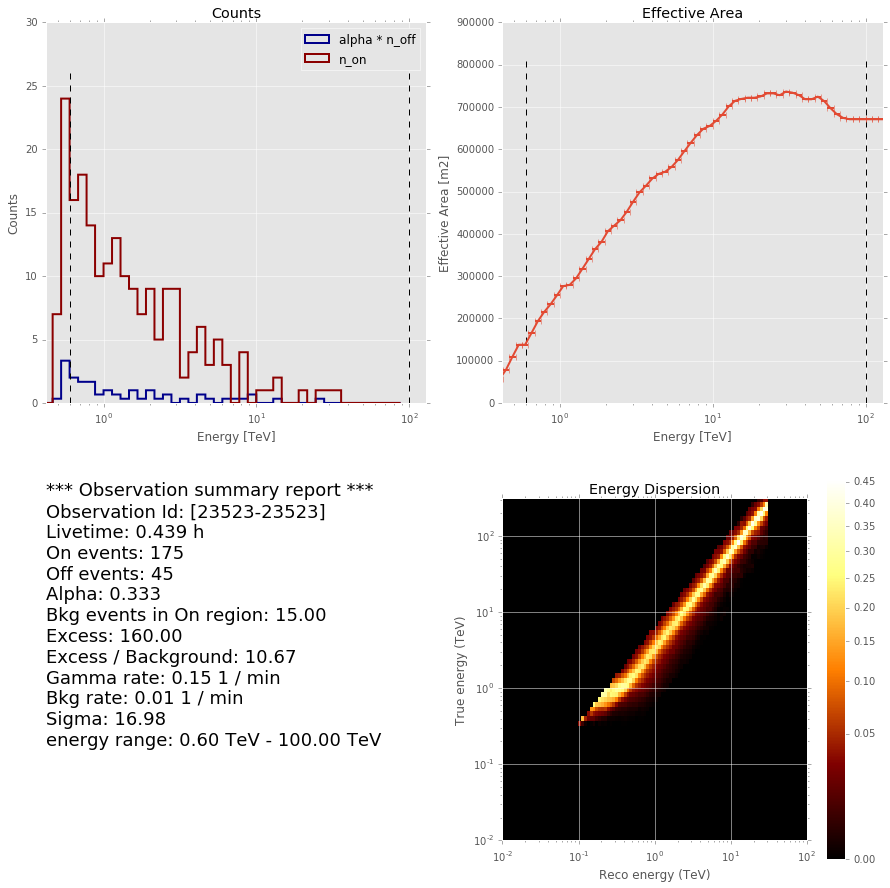

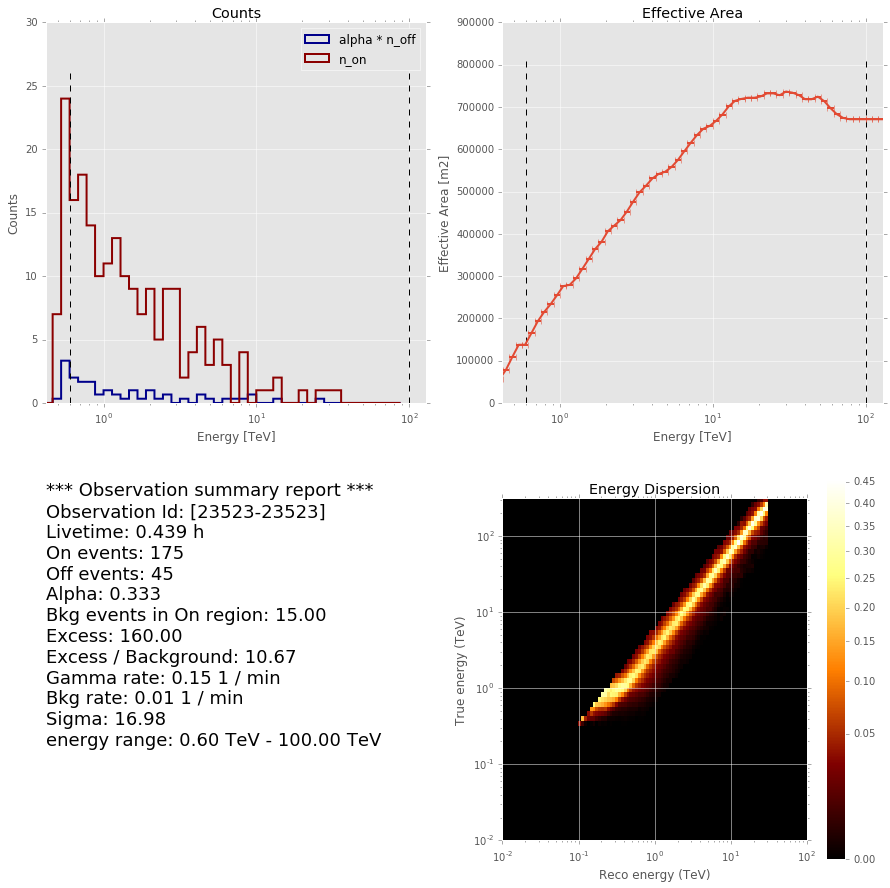

In [10]:
filename = ANALYSIS_DIR + '/ogip_data/pha_obs23523.fits'
obs = SpectrumObservation.read(filename)
obs.peek()

## Fit spectrum

Now we'll fit a global model to the spectrum. First we do a joint likelihood fit to all observations. If you want to stack the observations see below. We will also produce a debug plot in order to show how the global fit matches one of the individual observations.


Fit result info 
--------------- 
Model: PowerLaw
index : 2.17+/-0.04
reference : 1
amplitude : (2.16+/-0.10)e-07 

Statistic: 215.340 (wstat)
Covariance:
[u'index', u'amplitude']
[[  1.73510031e-03   1.68173899e-10]
 [  1.68173899e-10   9.92349842e-17]]
Fit Range: [  0.43629137  93.99612718] TeV



(<matplotlib.axes._subplots.AxesSubplot at 0x7fa01d45ee50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa01b6f7290>)

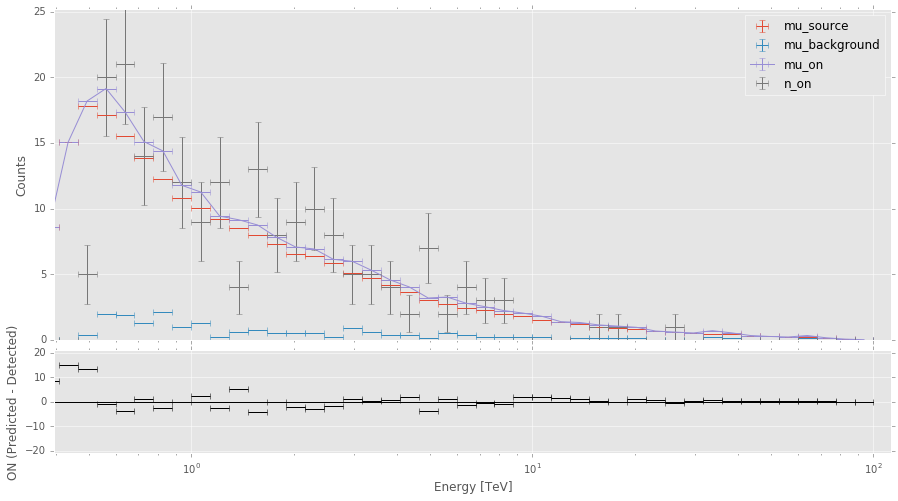

In [11]:
model = PowerLaw(index = 2 * u.Unit(''),
                amplitude = 2e-11 * u.Unit('cm-2 s-1 TeV-1'),
                reference = 1 * u.TeV)

fit = SpectrumFit(extraction.observations, model)
fit.run(outdir = ANALYSIS_DIR)

print(fit.global_result)
fit.result[1].plot()

## Compute Flux Points

To round up out analysis we can compute flux points by fitting the norm of the global model in energy bands. To get a sensible energy binning we require a 4 sigma detection in each energy band.

In [12]:
ebounds = [0.3, 1.1, 3, 10.1, 30] * u.TeV
stacked_obs = SpectrumObservation.stack(extraction.observations)

#Temporary fix - remove one SpectrumEnergyGroupMaker uses quality vector correctly
stacked_obs.hi_threshold = 80 * u.TeV
seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

print(seg)
print(seg.groups)

SpectrumEnergyGroupMaker:

Spectrum table:
Number of bins: 72
Bin range: (0, 71)
Energy range: EnergyRange(min=0.01 TeV, max=100.0 TeV)
SpectrumEnergyGroups:

Info including underflow- and overflow bins:
Number of groups: 6
Bin range: (0, 71)
Energy range: EnergyRange(min=0.01 TeV, max=100.0 TeV)

SpectrumEnergyGroups:

Info including underflow- and overflow bins:
Number of groups: 6
Bin range: (0, 71)
Energy range: EnergyRange(min=0.01 TeV, max=100.0 TeV)



/home/kingj/Software/gammapy/gammapy/stats/poisson.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  temp = (alpha + 1) / (n_on + n_off)
/home/kingj/Software/gammapy/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  l = n_on * log(n_on * temp / alpha)


In [13]:
fpe = FluxPointEstimator(
    obs=obs,
    groups=seg.groups,
    model=fit.model,
)
fpe.compute_points()

# TODO: change this attribute to be a flux points object directly
table = fpe.flux_points
table['ENERGY'] = table['energy']
table['ENERGY_ERR_HI'] = table['energy_err_hi']
table['ENERGY_ERR_LO'] = table['energy_err_lo']
table['DIFF_FLUX'] = table['diff_flux']
table['DIFF_FLUX_ERR_HI'] = table['diff_flux_err_hi']
table['DIFF_FLUX_ERR_LO'] = table['diff_flux_err_lo']
flux_points = DifferentialFluxPoints(table)

print(fpe)
flux_points.pprint()
flux_points.info()

FluxPointEstimator:
*** Observation summary report ***
Observation Id: [23523-23523]
Livetime: 0.439 h
On events: 175
Off events: 45
Alpha: 0.333
Bkg events in On region: 15.00
Excess: 160.00
Excess / Background: 10.67
Gamma rate: 0.15 1 / min
Bkg rate: 0.01 1 / min
Sigma: 16.98
energy range: 0.60 TeV - 100.00 TeV
SpectrumEnergyGroups:

Info including underflow- and overflow bins:
Number of groups: 6
Bin range: (0, 71)
Energy range: EnergyRange(min=0.01 TeV, max=100.0 TeV)

PowerLaw
index : 2
reference : 1 TeV
amplitude : 2e-11 1 / (cm2 s TeV)

 diff_flux_err_lo  diff_flux_err_hi ...  DIFF_FLUX_ERR_HI  DIFF_FLUX_ERR_LO
  1 / (m2 s TeV)    1 / (m2 s TeV)  ...   1 / (m2 s TeV)    1 / (m2 s TeV) 
----------------- ----------------- ... ----------------- -----------------
4.92528635035e-08 4.92528635035e-08 ... 4.92528635035e-08 4.92528635035e-08
9.62234566462e-09 9.62234566462e-09 ... 9.62234566462e-09 9.62234566462e-09
1.02910662876e-09 1.02910662876e-09 ... 1.02910662876e-09 1.029106628

/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/astropy/table/column.py:263: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self.data.__eq__(other)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa01d4352d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa013a13790>)

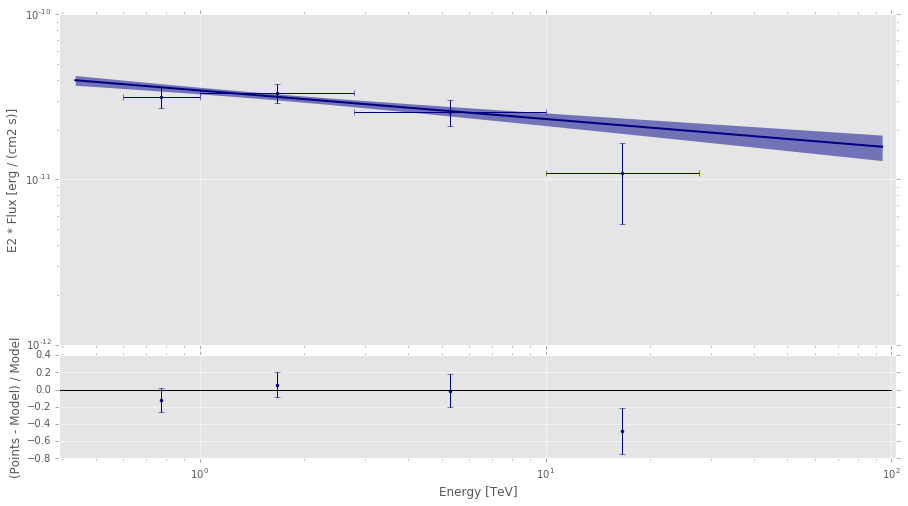

In [14]:
spectrum_result = SpectrumResult(
    points=flux_points,
    fit=fit.global_result,
)

spectrum_result.plot(
    energy_range=fit.global_result.fit_range,
    energy_power=2, flux_unit='erg-1 cm-2 s-1',
)

## Stack observations

And alternative approach to fitting the spectrum is stacking all observations first and the fitting a model to the stacked observation. This works as follows. A comparison to the joint likelihood fit is also printed.

In [15]:
stacked_obs = SpectrumObservation.stack(extraction.observations)
stacked_fit = SpectrumFit(stacked_obs, model)

# TODO: wait for https://github.com/sherpa/sherpa/pull/249
#stacked_fit.fit()
#print(stacked_fit.result[0])

#stacked_table = stacked_fit.result[0].to_table(format='.3g')
#stacked_table['method'] = 'stacked'
#joint_table = fit.global_result.to_table(format='.3g')
#joint_table['method'] = 'joint'
# from astropy.table import vstack as vstack_table
#print(vstack_table([stacked_table, joint_table])['method', 'index', 'index_err', 'amplitude', 'amplitude_err'])

## Exercises

Some things we might do:

- Fit a different spectral model (ECPL or CPL or ...)
- Use different method or parameters to compute the flux points
- Do a chi^2 fit to the flux points and compare

TODO: give pointers how to do this (and maybe write a notebook with solutions)

In [16]:
# Start the exercises here!

## What next?

In this tutorial we learned ... TODO.

Here's some suggestions where to go next:

* if you interested in available fit statistics checkout [gammapy.stats](docs.gammapy.org/en/latest/stats/index.html?highlight=gammapy.stats)
* if you want to simulate spectral look at [this tutorial](http://docs.gammapy.org/en/latest/spectrum/simulation.html)
* if you want to compare your spectra to e.g. Fermi spectra published in catalogs have a look at [this](http://docs.gammapy.org/en/latest/spectrum/plotting_fermi_spectra.html)